<div style="background: linear-gradient(90deg, #0f2027 0%, #2c5364 100%); color:#fff; padding:32px 30px 28px 30px; border-radius:20px; box-shadow: 0 8px 32px 0 rgba(44,83,100,0.35); font-size:20px; font-family:'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; margin-bottom: 28px;">
  <h1 style="color:#7cf9ff; margin-top:0; font-size:2.5em; letter-spacing:1px; text-shadow:0 2px 10px #111;">📚 Table of Contents</h1>
  <ul style="list-style:none; padding-left:0; margin-top:18px;">
    <li style="margin-bottom:10px;"><a href="#setup-data-loading" style="color:#ffe066; font-weight:bold; font-size:1.1em;">1. Setup & Data Loading</a></li>
    <li style="margin-bottom:10px;"><a href="#data-cleaning-feature-engineering" style="color:#ffe066; font-weight:bold; font-size:1.1em;">2. Data Cleaning & Feature Engineering</a></li>
    <li style="margin-bottom:10px;"><a href="#summary-statistics-key-metrics" style="color:#ffe066; font-weight:bold; font-size:1.1em;">3. Summary Statistics & Key Metrics</a></li>
    <li style="margin-bottom:10px;"><a href="#anomaly-detection" style="color:#ffe066; font-weight:bold; font-size:1.1em;">4. Anomaly Detection</a></li>
    <li style="margin-bottom:10px;"><a href="#interactive-visualizations" style="color:#ffe066; font-weight:bold; font-size:1.1em;">5. Interactive Visualizations</a></li>
    <li style="margin-bottom:10px;"><a href="#additional-professional-visuals" style="color:#ffe066; font-weight:bold; font-size:1.1em;">6. Additional Professional Visuals</a></li>
    <li style="margin-bottom:10px;"><a href="#risk-metrics-visualization" style="color:#ffe066; font-weight:bold; font-size:1.1em;">7. Risk Metrics Visualization</a></li>
  <div style="margin-top:22px; font-size:1em; color:#b3e0ff;">
    <b>Tip:</b> Click any section to jump directly to it. <br>
    For best navigation, use matching anchor tags or markdown headers in each section.
  </div>
</div>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-stocks-historical-data/Google_stock_data.csv


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🚀 Step 1: Setup & Data Loading</h2>
  <p></p>
</div>


In [2]:
# Install Prophet (the new name for fbprophet)
!pip install --quiet prophet


In [3]:
# Step 1: Setup & Data Loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from prophet import Prophet

# Load the data from Kaggle input directory
df = pd.read_csv("/kaggle/input/google-stocks-historical-data/Google_stock_data.csv")
# Preview data
df.head()


,Date,Close,High,Low,Open,Volume
0,2004-08-19,2.484366,2.576470,2.375919,2.475947,897427216
1,2004-08-20,2.681699,2.700763,2.488327,2.500954,458857488
2,2004-08-23,2.708686,2.809705,2.700021,2.742111,366857939
3,2004-08-24,2.596526,2.763157,2.564338,2.754244,306396159
4,2004-08-25,2.624503,2.674023,2.572013,2.598753,184645512


In [4]:
print(df.isnull().sum())

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🧹 Step 2: Data Cleaning & Feature Engineering</h2>
  <p></p>
</div>


In [5]:
# Step 2: Data Cleaning & Feature Engineering

# Drop missing values
df.dropna(inplace=True)

# Ensure correct data types
df[['Close', 'High', 'Low', 'Open']] = df[['Close', 'High', 'Low', 'Open']].astype(float)
df['Volume'] = df['Volume'].astype(int)

# Daily Returns
df['Daily Return'] = df['Close'].pct_change()

# Moving Averages
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Bollinger Bands
rolling_std = df['Close'].rolling(window=20).std()
df['BB_upper'] = df['MA20'] + (rolling_std * 2)
df['BB_lower'] = df['MA20'] - (rolling_std * 2)

# RSI Calculation
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI14'] = compute_rsi(df['Close'])

# MACD Calculation
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

df.tail()


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


,Date,Close,High,Low,Open,Volume,Daily Return,MA20,MA50,BB_upper,BB_lower,RSI14,MACD,MACD_signal
5250,2025-07-02,179.759995,179.934998,176.089996,176.544998,19325900,0.016110,174.583137,168.540009,183.372213,165.794061,51.453403,2.092825,1.850224
5251,2025-07-03,180.550003,180.770004,178.190002,179.820007,13287400,0.004395,175.151305,169.076705,183.940680,166.361931,55.534942,2.368351,1.953849
5252,2025-07-07,177.559998,180.339996,176.639999,180.134995,20991400,-0.016561,175.548999,169.477292,183.995011,167.102987,52.453259,2.318710,2.026821
5253,2025-07-08,175.160004,178.789993,173.919998,178.779999,24108600,-0.013517,175.571500,169.754969,184.010495,167.132504,45.980339,2.061941,2.033845
5254,2025-07-09,177.660004,180.279999,173.880005,176.110001,31260700,0.014273,175.573000,170.035103,184.013546,167.132453,50.591157,2.036701,2.034417


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">📊 Step 3: Summary Statistics & Key Metrics</h2>
  <p></p>
</div>


In [6]:
# Ensure 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'])

print("Summary Statistics:")
display(df.describe())

print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")

max_close = df.loc[df['Close'].idxmax()]
min_close = df.loc[df['Close'].idxmin()]
print(f"Highest Close: {max_close['Close']:.2f} on {max_close['Date'].date()}")
print(f"Lowest Close: {min_close['Close']:.2f} on {min_close['Date'].date()}")

volatility = df['Daily Return'].std()
print(f"Daily Return Volatility: {volatility:.4f}")

sharpe_ratio = df['Daily Return'].mean() / volatility * np.sqrt(252)
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")

df['Cumulative Return'] = (1 + df['Daily Return']).cumprod()
df['Cumulative Roll Max'] = df['Cumulative Return'].cummax()
df['Drawdown'] = df['Cumulative Return'] / df['Cumulative Roll Max'] - 1
max_drawdown = df['Drawdown'].min()
print(f"Max Drawdown: {max_drawdown:.2%}")


Summary Statistics:


,Date,Close,High,Low,Open,Volume,Daily Return,MA20,MA50,BB_upper,BB_lower,RSI14,MACD,MACD_signal
count,5255,5255.000000,5255.000000,5255.000000,5255.000000,5.255000e+03,5254.000000,5236.000000,5206.000000,5236.000000,5236.000000,5242.000000,5255.000000,5255.000000
mean,2015-01-25 07:34:03.539486208,50.701863,51.228313,50.162980,50.682628,1.115415e+08,0.000999,50.562188,50.350282,53.485278,47.639098,54.546898,0.226699,0.225151
min,2004-08-19 00:00:00,2.476194,2.519028,2.375919,2.455892,1.584340e+05,-0.116091,2.606689,3.145611,2.816451,2.318057,4.789720,-7.018805,-5.912105
25%,2009-11-04 12:00:00,13.145051,13.293855,13.013207,13.173276,2.626400e+07,-0.008013,13.206475,13.315753,14.030773,12.281274,41.883926,-0.147132,-0.138881
50%,2015-01-27 00:00:00,28.180237,28.492454,27.929177,28.246586,4.985200e+07,0.000804,28.204083,28.178796,29.355367,26.853271,54.741123,0.144438,0.144556
75%,2020-04-15 12:00:00,70.216625,71.075024,69.166863,70.136340,1.357208e+08,0.010268,70.031192,68.349341,73.453363,65.858591,67.023801,0.514483,0.510356
max,2025-07-09 00:00:00,207.224548,208.212225,203.782599,204.022044,1.650833e+09,0.199915,197.699364,193.201798,209.052360,189.193079,99.163067,6.064992,5.351150
std,NaN,49.767877,50.312742,49.224165,49.743728,1.477101e+08,0.019348,49.480591,49.061386,52.456029,46.570518,17.005176,1.285290,1.206617


Date Range: 2004-08-19 to 2025-07-09
Highest Close: 207.22 on 2025-02-04
Lowest Close: 2.48 on 2004-09-03
Daily Return Volatility: 0.0193
Annualized Sharpe Ratio: 0.82
Max Drawdown: -65.29%


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🚨 Step 4: Anomaly Detection</h2>
  <p></p>
</div>


In [7]:
# Step 4: Anomaly Detection

return_threshold = 3 * volatility
anomalies_return = df[abs(df['Daily Return']) > return_threshold]

volume_threshold = df['Volume'].mean() + 3 * df['Volume'].std()
anomalies_volume = df[df['Volume'] > volume_threshold]

print(f"Anomalies in Daily Return (>|3σ|): {len(anomalies_return)} days")
display(anomalies_return[['Date', 'Daily Return', 'Close']])

print(f"Anomalies in Volume (>|3σ|): {len(anomalies_volume)} days")
display(anomalies_volume[['Date', 'Volume', 'Close']])


Anomalies in Daily Return (>|3σ|): 82 days


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


,Date,Daily Return,Close
1,2004-08-20,0.079430,2.681699
27,2004-09-28,0.072721,3.140986
44,2004-10-21,0.063279,3.698569
45,2004-10-22,0.154305,4.269276
46,2004-10-25,0.086818,4.639925
...,...,...,...
4895,2024-01-31,-0.073505,140.962097
4955,2024-04-26,0.099652,172.663666
5149,2025-02-05,-0.069376,192.848221
5193,2025-04-09,0.098786,160.866638


Anomalies in Volume (>|3σ|): 112 days


,Date,Volume,Close
0,2004-08-19,897427216,2.484366
28,2004-09-29,613229953,3.245471
44,2004-10-21,585767401,3.698569
45,2004-10-22,1481207196,4.269276
46,2004-10-25,1315480331,4.639925
...,...,...,...
922,2008-04-18,732158060,13.355505
1048,2008-10-16,652022815,8.740587
1049,2008-10-17,572104380,9.223893
1551,2010-10-15,595214680,14.891583


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">📈 Step 5: Interactive Visualizations</h2>
  <p></p>
</div>


In [8]:
# Step 5: Interactive Visualizations with Plotly

import plotly.io as pio
pio.renderers.default = 'iframe'  # Ensures visuals appear in Kaggle output

# Closing Price with MA and Bollinger Bands
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Close Price'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA20'], mode='lines', name='MA20', line=dict(dash='dash')))
fig.add_trace(go.Scatter(x=df['Date'], y=df['MA50'], mode='lines', name='MA50', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=df['Date'], y=df['BB_upper'], mode='lines', name='BB Upper', line=dict(color='rgba(255,0,0,0.2)')))
fig.add_trace(go.Scatter(x=df['Date'], y=df['BB_lower'], mode='lines', name='BB Lower', line=dict(color='rgba(0,0,255,0.2)')))
fig.update_layout(title='Google Stock Price with Moving Averages & Bollinger Bands',
                  xaxis_title='Date', yaxis_title='Price (USD)', template='plotly_dark')
fig.show()

In [9]:
# RSI and MACD subplot
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                    subplot_titles=('Closing Price', 'RSI (14)', 'MACD'),
                    row_heights=[0.5, 0.25, 0.25])

fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close Price'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['RSI14'], name='RSI14', line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['MACD'], name='MACD', line=dict(color='green')), row=3, col=1)
fig.add_trace(go.Scatter(x=df['Date'], y=df['MACD_signal'], name='MACD Signal', line=dict(color='red', dash='dash')), row=3, col=1)

fig.update_yaxes(title_text='Price', row=1, col=1)
fig.update_yaxes(title_text='RSI', row=2, col=1, range=[0, 100])
fig.update_yaxes(title_text='MACD', row=3, col=1)
fig.update_layout(height=800, template='plotly_dark', title_text="Technical Indicators")
fig.show()

In [10]:
# Daily Returns Distribution
fig = px.histogram(df, x='Daily Return', nbins=100, title='Distribution of Daily Returns', template='plotly_dark')
fig.update_layout(bargap=0.1)
fig.show()

In [11]:
# Daily Returns Distribution
fig = px.histogram(df, x='Close', nbins=100, title='Distribution of Close', template='plotly_dark')
fig.update_layout(bargap=0.1)
fig.show()

<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🔬 Step 5A: Scatter Plot — Volume vs. Close Price</h2>
  <p>Scatter plots are excellent for identifying relationships and outliers between two variables. Here, we visualize the relationship between daily trading volume and closing price, a classic tool for professional risk and anomaly analysis.</p>
</div>


In [12]:
# Scatter Plot: Volume vs. Close Price
fig = px.scatter(
    df, x="Volume", y="Close",
    title="Relationship between Trading Volume and Closing Price",
    labels={"Volume": "Trading Volume", "Close": "Closing Price (USD)"},
    color="Daily Return",
    color_continuous_scale="Viridis",
    template="plotly_dark"
)
fig.show()


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">📦 Step 5B: Box Plot — Distribution of Daily Returns</h2>
  <p>Box plots summarize the distribution of returns, showing median, quartiles, and outliers. This helps professionals quickly assess volatility and the presence of extreme events in the return series.</p>
</div>


In [13]:
features = ['Close', 'High', 'Low', 'Open']
df_long = df[features].melt(var_name='Feature', value_name='Value')
fig = px.box(
    df_long, x="Feature", y="Value",
    title="Box Plot of Selected Features",
    points="all",
    template="plotly_dark",
    color_discrete_sequence=["#7cf9ff"]
)
fig.show()

In [14]:
# Box Plot: Distribution of Daily Returns
fig = px.box(
    df, y="Volume",
    title="Box Plot of Daily Returns",
    points="all",  # show all outliers
    template="plotly_dark",
    color_discrete_sequence=["#7cf9ff"]
)
fig.show()


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🌡️ Step 5C: Heatmap — Correlation Matrix</h2>
  <p>Heatmaps are powerful for visualizing correlations between financial variables. This helps professionals understand which metrics move together and informs risk management and portfolio construction.</p>
</div>


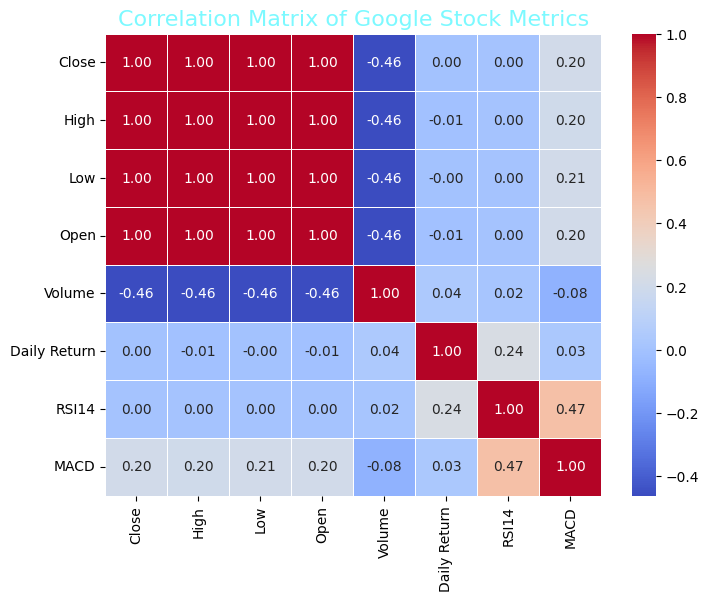

In [15]:
# Heatmap: Correlation Matrix of Key Metrics
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(
    df[["Close", "High", "Low", "Open", "Volume", "Daily Return", "RSI14", "MACD"]].corr(),
    annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
)
plt.title("Correlation Matrix of Google Stock Metrics", color="#7cf9ff", fontsize=16)
plt.show()


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">🕯️ Step 5D: Candlestick Chart — Price Action Analysis</h2>
  <p>Candlestick charts are a staple for professional traders, showing open, high, low, and close prices for each day. They help spot patterns, reversals, and key support/resistance levels.</p>
</div>


In [16]:
# Candlestick Chart: Price Action Analysis
fig = go.Figure(
    data=[
        go.Candlestick(
            x=df["Date"],
            open=df["Open"],
            high=df["High"],
            low=df["Low"],
            close=df["Close"],
            increasing_line_color="#00e676",
            decreasing_line_color="#ff1744",
            name="Candlestick"
        )
    ]
)
fig.update_layout(
    title="Google Stock Candlestick Chart",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    template="plotly_dark"
)
fig.show()


<div style="background-color:#232038; color:#f3f3f3; padding:22px; border-radius:14px; font-size:18px; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;">
  <h2 style="color:#7cf9ff; margin-top:0;">⚠️ Step 6: Risk Metrics Visualization</h2>
  <p></p>
</div>


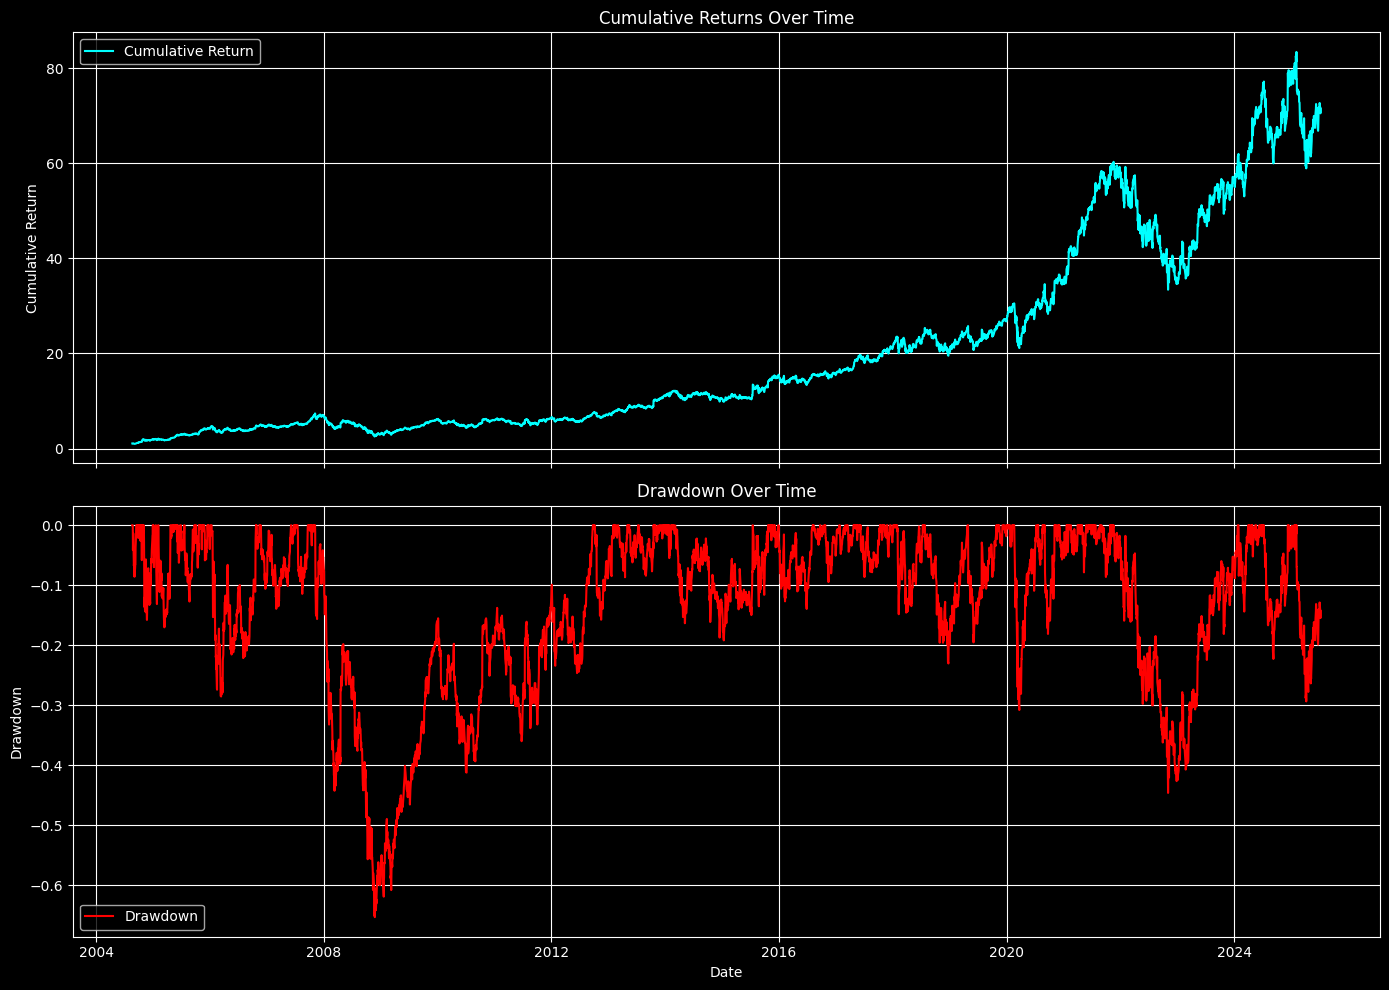

In [17]:
# Step 6: Risk Metrics Visualization

plt.style.use('dark_background')
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

ax[0].plot(df['Date'], df['Cumulative Return'], label='Cumulative Return', color='cyan')
ax[0].set_title('Cumulative Returns Over Time')
ax[0].set_ylabel('Cumulative Return')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(df['Date'], df['Drawdown'], label='Drawdown', color='red')
ax[1].set_title('Drawdown Over Time')
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('Date')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()
